In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

Training Transformer model for sorting sequences of length 10...
Epoch 0: Loss = 3.3462, Accuracy = 0.0547
Input:    [12, 14, 12, 14, 19, 8, 1, 13, 17, 2]
Expected: [1, 2, 8, 12, 12, 13, 14, 14, 17, 19]
Predicted: [1, 1, 4, 8, 12, 9, 3, 13, 14, 7]
--------------------------------------------------
Epoch 50: Loss = 1.4262, Accuracy = 0.5406
Epoch 100: Loss = 0.7110, Accuracy = 0.7703
Input:    [4, 17, 6, 14, 14, 15, 13, 11, 7, 19]
Expected: [4, 6, 7, 11, 13, 14, 14, 15, 17, 19]
Predicted: [4, 6, 6, 11, 14, 14, 14, 14, 17, 19]
--------------------------------------------------
Epoch 150: Loss = 0.3591, Accuracy = 0.8953
Epoch 200: Loss = 0.2322, Accuracy = 0.9438
Input:    [18, 12, 18, 2, 1, 7, 4, 5, 16, 4]
Expected: [1, 2, 4, 4, 5, 7, 12, 16, 18, 18]
Predicted: [1, 2, 4, 4, 5, 7, 12, 16, 18, 18]
--------------------------------------------------
Epoch 250: Loss = 0.1472, Accuracy = 0.9688
Epoch 299: Loss = 0.0856, Accuracy = 0.9859
Input:    [9, 12, 10, 12, 17, 16, 11, 9, 19, 2]
Expecte

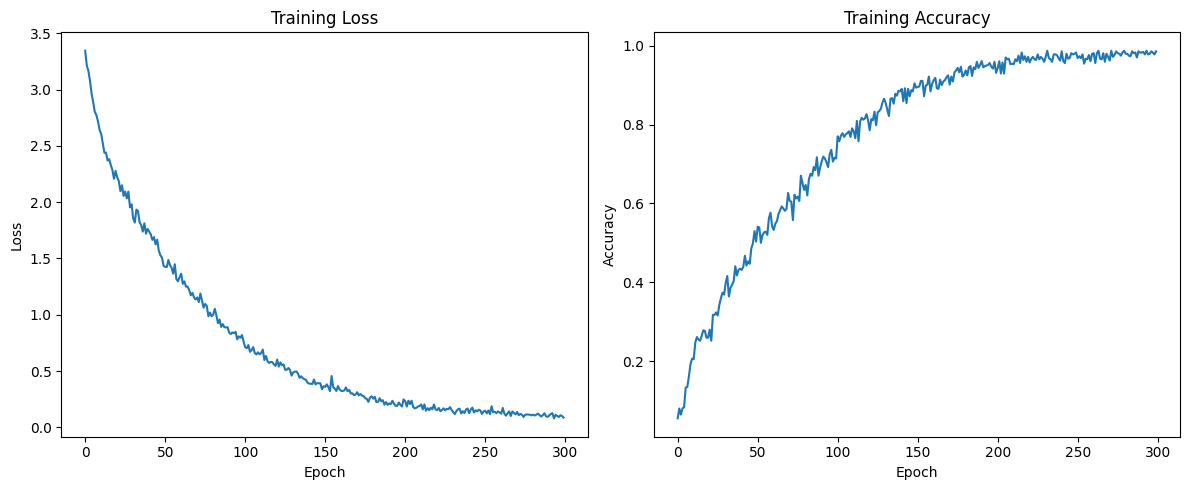


Model Evaluation:
--------------------------------------------------
Example 1:
Input:    [16, 3, 5, 7, 14, 4, 14, 4, 13, 18]
Expected: [3, 4, 4, 5, 7, 13, 14, 14, 16, 18]
Predicted: [3, 4, 4, 5, 7, 13, 14, 14, 16, 18]
Correct: True
------------------------------
Example 2:
Input:    [7, 3, 8, 12, 12, 9, 5, 18, 5, 8]
Expected: [3, 5, 5, 7, 8, 8, 9, 12, 12, 18]
Predicted: [3, 5, 5, 7, 8, 8, 9, 12, 12, 18]
Correct: True
------------------------------
Example 3:
Input:    [9, 1, 1, 15, 7, 9, 4, 18, 7, 2]
Expected: [1, 1, 2, 4, 7, 7, 9, 9, 15, 18]
Predicted: [1, 2, 2, 4, 7, 7, 9, 9, 15, 18]
Correct: False
------------------------------
Example 4:
Input:    [17, 12, 2, 3, 9, 13, 17, 12, 3, 7]
Expected: [2, 3, 3, 7, 9, 12, 12, 13, 17, 17]
Predicted: [2, 3, 3, 7, 9, 12, 12, 13, 17, 17]
Correct: True
------------------------------
Example 5:
Input:    [7, 6, 6, 8, 5, 2, 15, 18, 1, 15]
Expected: [1, 2, 5, 6, 6, 7, 8, 15, 15, 18]
Predicted: [1, 2, 5, 6, 6, 7, 8, 15, 15, 18]
Correct: True
------

In [3]:
def generate_data(batch_size, seq_length, vocab_size):
    """
    Generates random sequences of integers and their sorted counterparts.
    """
    src = torch.randint(1, vocab_size, (batch_size, seq_length))
    tgt = torch.sort(src, dim=1)[0]
    return src, tgt

class IntegerSequenceEmbedding(nn.Module):
    """
    Embedding module that combines token embeddings with positional encodings.
    """
    def __init__(self, vocab_size=20, embed_dim=16, seq_length=5):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size+1, embed_dim)  #+1 for padding
        self.positional_embedding = nn.Embedding(seq_length, embed_dim)

    def forward(self, x):
        """
        Forward pass of the embedding module.
        """
        x = self.token_embedding(x)  #(batch_size, seq_length, embed_dim)
        positions = torch.arange(x.shape[1], device=x.device).unsqueeze(0)
        x = x + self.positional_embedding(positions)

        return x

class SingleHeadAttention(nn.Module):
    """
    Implements the self-attention mechanism.
    """
    def __init__(self, embed_dim):
        super().__init__()
        self.W_q = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)
        self.attention_weights = None

    def forward(self, x):
        """
        Forward pass for the self-attention mechanism.
        """
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        d_k = K.shape[-1]  #Key dimension

        # Compute attention scores
        scores = Q @ K.transpose(1, 2)
        scores = scores / (d_k ** 0.5)
        scores = torch.softmax(scores, dim=-1)

        self.attention_weights = scores

        # Apply attention scores to values
        output = scores @ V

        return output

class TransformerEncoderLayer(nn.Module):
    """
    A single Transformer encoder layer.
    """
    def __init__(self, embed_dim, ff_dim=None):
        super().__init__()
        if ff_dim is None:
            ff_dim = embed_dim *2

        self.self_attn = SingleHeadAttention(embed_dim)

        # Normalization layers
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Feed-forward network
        self.fc_layers = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )

    def forward(self, x):
        """
        Forward pass with residual connections.
        """
        x = x+ self.self_attn(self.norm1(x))
        x = x +self.fc_layers(self.norm2(x))

        return x

class Transformer(nn.Module):
    """
    Full Transformer model for sequence sorting.
    """
    def __init__(self, vocab_size, embed_dim, seq_length=10, num_layers=2):
        super().__init__()

        # Token embedding layer
        self.embedding = IntegerSequenceEmbedding(vocab_size, embed_dim, seq_length)

        # Stack of Transformer Encoder Layers
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim) for _ in range(num_layers)
        ])

        #Final classification head
        self.fc_out = nn.Linear(embed_dim, vocab_size+1)

    def forward(self, x):
        """
        Forward pass of the Transformer.
        """
        x = self.embedding(x)
        for layer in self.encoder_layers:
            x = layer(x)

        outputs = self.fc_out(x)

        return outputs

def train_model(model, num_epochs=500, batch_size=32, vocab_size=20, seq_length=10):
    """
    Train the Transformer model on the sorting task.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_history = []
    accuracy_history = []

    # training loop
    for epoch in range(num_epochs):
        src, tgt = generate_data(batch_size, seq_length, vocab_size)
        optimizer.zero_grad()
        output = model(src)
        loss = criterion(output.reshape(-1, output.shape[-1]), tgt.reshape(-1))
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        # accuracy of how many numbers are correctly sorted
        with torch.no_grad():
            predictions = output.argmax(dim=-1)
            correct = (predictions == tgt).float().mean()
            accuracy_history.append(correct.item())

        if epoch % 50 == 0 or epoch == num_epochs-1:
            print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Accuracy = {correct.item():.4f}")

            if epoch % 100 == 0 or epoch == num_epochs-1:
                test_src, test_tgt = generate_data(1, seq_length, vocab_size)
                test_pred = model(test_src).argmax(dim=-1)
                print(f"Input:    {test_src[0].tolist()}")
                print(f"Expected: {test_tgt[0].tolist()}")
                print(f"Predicted: {test_pred[0].tolist()}")
                print("-" * 50)

    return model, loss_history, accuracy_history

def plot_results(loss_history, accuracy_history):
    """
    Plot training metrics.
    """
    plt.figure(figsize=(12, 5))

    # loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    #accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.savefig('transformer_training_results.png')
    plt.show()

def evaluate_model(model, num_examples=5, seq_length=10, vocab_size=20):
    """
    Evaluate the model on new examples.
    """
    model.eval()
    all_correct = True

    print("\nModel Evaluation:")
    print("-" * 50)

    for i in range(num_examples):
        test_src, test_tgt = generate_data(1, seq_length, vocab_size)

        with torch.no_grad():
            test_pred = model(test_src).argmax(dim=-1)

        # Check if sorting is correct
        is_correct = torch.equal(test_pred, test_tgt)
        all_correct = all_correct and is_correct

        print(f"Example {i+1}:")
        print(f"Input:    {test_src[0].tolist()}")
        print(f"Expected: {test_tgt[0].tolist()}")
        print(f"Predicted: {test_pred[0].tolist()}")
        print(f"Correct: {is_correct}")
        print("-" * 30)

    print(f"\nOverall result: {'All correct!' if all_correct else 'Some errors found.'}")
    return all_correct

def main():

    # Constants
    vocab_size = 20 # Numbers from 1 to 20
    embed_dim = 64 # Sequence length
    seq_length = 10
    num_layers = 3
    batch_size = 64
    num_epochs = 300

    model = Transformer(vocab_size, embed_dim, seq_length, num_layers)

    # Train the model
    print(f"Training Transformer model for sorting sequences of length {seq_length}...")
    model, loss_history, accuracy_history = train_model(
        model,
        num_epochs=num_epochs,
        batch_size=batch_size,
        vocab_size=vocab_size,
        seq_length=seq_length)

    plot_results(loss_history, accuracy_history)
    evaluate_model(model, num_examples=5, seq_length=seq_length)


if __name__ == "__main__":
    main()